## EDA using Million Playlist Database in SQLite
**Author:** Jamilla Akhund-Zade

### Introduction:
The Million Playlist Data (MPD) in its raw format is made up of CSVs 0 through 999, each with 1000 playlists. The raw MPD was merged into a single CSV file called 'combined_playlist_v2.csv'. This CSV file has an extra row denoting what CSV file the playlist came from.

The columns of the MPD are as follows:

1. **pid:** playlist ID within the original CSV
2. **pos:** position of song within the playlist
3. **artist_name:** name of the artist (string)
4. **track_uri:** unique track Spotify Identifier
5. **artist_uri:** unique artist Spotify Identifier
6. **track_name:** name of the track (string)
7. **album_uri:** unique album Spotify Identifier
8. **duration_ms:** track duration in ms
9. **album_name:** name of album
10. **file_name:** identifier of CSV where playlists came from
11. **pidfile_name:** unique playlist identifier

The MPD is 12GB, which is too large to hold in memory, so I will create an SQLite database so that I can do EDA efficiently, while the data is held out-of-memory. I will use the MacOS built-in SQLite command-line tools:

```
> sqlite3
sqlite> .open mpd.db #open brand-new database
sqlite> CREATE TABLE mpd(
    pid INTEGER,
    pos INTEGER,
    artist_name TEXT,
    track_uri TEXT,
    artist_uri TEXT,
    track_name TEXT,
    album_uri TEXT,
    duration_ms INTEGER,
    album_name TEXT,
    file_name TEXT,
    pidfile_name TEXT
);
sqlite> .mode csv #set mode to csv
sqlite> .import combined_playlist_v2.csv mpd #import csv data to table mpd

#create artist table
CREATE TABLE artists (
   id INTEGER NOT NULL PRIMARY KEY,
   artist_uri TEXT NOT NULL,
   artist_name TEXT NOT NULL
);
INSERT INTO artists(artist_uri, artist_name) SELECT DISTINCT artist_uri, artist_name FROM mpd;

#create album table
CREATE TABLE albums (
   id INTEGER NOT NULL PRIMARY KEY,
   album_uri TEXT NOT NULL,
   album_name TEXT NOT NULL
);
INSERT INTO albums(album_uri, album_name) SELECT DISTINCT album_uri, album_name FROM mpd;

#create song table
CREATE TABLE songs (
   track_id INTEGER NOT NULL PRIMARY KEY,
   track_uri TEXT NOT NULL,
   track_name TEXT NOT NULL,
   duration_ms INTEGER NOT NULL,
   artist_uri TEXT NOT NULL,
   album_uri TEXT NOT NULL
);
INSERT INTO songs(track_uri, track_name, duration_ms, artist_uri, album_uri) 
SELECT DISTINCT track_uri, track_name, duration_ms, artist_uri, album_uri FROM mpd;

ALTER TABLE songs RENAME TO old_songs;

CREATE TABLE songs AS
SELECT track_id, track_uri, track_name, duration_ms, artists.id AS artist_id, albums.id AS album_id
FROM old_songs
LEFT JOIN artists ON old_songs.artist_uri = artists.artist_uri
LEFT JOIN albums ON old_songs.album_uri = albums.album_uri;

DROP TABLE old_songs;

PRAGMA foreign_keys = ON;
ALTER TABLE songs RENAME TO old_songs;
CREATE TABLE songs (
   track_id INTEGER NOT NULL PRIMARY KEY,
   track_uri TEXT NOT NULL,
   track_name TEXT NOT NULL,
   duration_ms INTEGER NOT NULL,
   artist_id INTEGER NOT NULL,
   album_id INTEGER NOT NULL,
   FOREIGN KEY (artist_id) REFERENCES artists(id),
   FOREIGN KEY (album_id) REFERENCES albums(id)  
);
INSERT INTO songs
SELECT * FROM old_songs;

DROP TABLE old_songs;

PRAGMA foreign_keys = OFF;

#create playlist table
ALTER TABLE mpd RENAME TO old_mpd;

CREATE TABLE mpd AS
SELECT pid, pos, songs.track_id AS track_id, file_name, pidfile_name
FROM old_mpd
LEFT JOIN songs ON old_mpd.track_uri = songs.track_uri;

ALTER TABLE mpd RENAME TO temp_mpd;
CREATE TABLE mpd (
   id INTEGER NOT NULL PRIMARY KEY,
   pid INTEGER NOT NULL,
   pos INTEGER NOT NULL,
   track_id INTEGER NOT NULL,
   file_name TEXT NOT NULL,
   pidfile_name TEXT NOT NULL,
   FOREIGN KEY (track_id) REFERENCES songs(track_id)
);
INSERT INTO mpd(pid, pos, track_id, file_name, pidfile_name)
SELECT pid, pos, track_id, file_name, pidfile_name FROM temp_mpd;

DROP TABLE temp_mpd, old_mpd;

PRAGMA foreign_keys = OFF;
```

In [32]:
#load libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#connect to sqlite database
con = sqlite3.connect("/Users/jamillaakhund-zade/CS109A/Spotify_Project/data/mpd.db")

In [3]:
#examine structure of artists/albums table
df = pd.read_sql_query('SELECT * FROM artists LIMIT 5', con)
df.head()

,id,artist_uri,artist_name
0,1,spotify:artist:0MeLMJJcouYXCymQSHPn8g,Sleeping At Last
1,2,spotify:artist:7w0qj2HiAPIeUcoPogvOZ6,Rachael Yamagata
2,3,spotify:artist:32ogthv0BdaSMPml02X9YB,The Cinematic Orchestra
3,4,spotify:artist:3qnGvpP8Yth1AqSBMqON5x,Leon Bridges
4,5,spotify:artist:1ihU4zSTmY0qQXhx8jEXWT,Ryan Amador


In [4]:
#examine structure of songs table
df = pd.read_sql_query('SELECT * FROM songs LIMIT 5', con)
df.head()

#artist_id and album_id are foreign keys referencing primary keys of albums and artists tables

,track_id,track_uri,track_name,duration_ms,artist_id,album_id
0,1,spotify:track:2d7LPtieXdIYzf7yHPooWd,Chasing Cars,242564,1,1
1,2,spotify:track:0y4TKcc7p2H6P0GJlt01EI,Elephants,253701,2,2
2,3,spotify:track:6q4c1vPRZREh7nw3wG7Ixz,That Home,103920,3,3
3,4,spotify:track:54KFQB6N4pn926IUUYZGzK,To Build A Home,371320,3,3
4,5,spotify:track:0NeJjNlprGfZpeX2LQuN6c,River,238560,4,4


In [5]:
#examine structure of songs table
df = pd.read_sql_query('SELECT * FROM mpd LIMIT 5', con)
df.head()

#track_id is a foreign key referencing the primary key of songs

,id,pid,pos,track_id,file_name,pidfile_name
0,1,0,0,1,songs284,0songs284
1,2,0,1,2,songs284,0songs284
2,3,0,2,3,songs284,0songs284
3,4,0,3,4,songs284,0songs284
4,5,0,4,5,songs284,0songs284


In [6]:
#count number of unique records
cur = con.cursor() #cursor to hold query results

cur.execute('SELECT MAX(id) FROM mpd') 
#note: this only works accurately since mpd is a static table, where rows are not inserted/deleted
print(f'Total records: {cur.fetchone()[0]}')

Total records: 66346428


In [7]:
#count distinct songs
cur = con.cursor() #cursor to hold query results

cur.execute('SELECT MAX(track_id) FROM songs')
print(f'unique songs: {cur.fetchone()[0]}')

unique songs: 2262292


In [8]:
#distribution of playlist lengths
pl_length = pd.read_sql_query('SELECT COUNT(track_id) AS num_songs, pidfile_name FROM mpd GROUP BY pidfile_name',con)
pl_length.shape

(1000000, 2)

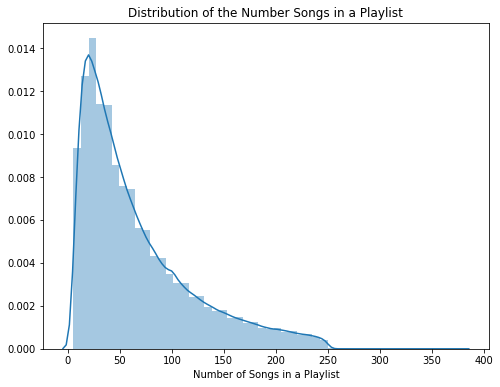

In [38]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax = sns.distplot(pl_length['num_songs'])
ax.set_xlabel('Number of Songs in a Playlist')
ax.set_title('Distribution of the Number Songs in a Playlist');

In [10]:
#summary stats
pl_length['num_songs'].describe()

count    1000000.000000
mean          66.346428
std           53.669358
min            5.000000
25%           26.000000
50%           49.000000
75%           92.000000
max          376.000000
Name: num_songs, dtype: float64

In [11]:
#distribution of playlist durations
pl_dur = pd.read_sql_query('SELECT SUM(duration_ms) AS total_dur, pidfile_name FROM mpd \
                        JOIN songs ON mpd.track_id = songs.track_id \
                        GROUP BY pidfile_name',con)
pl_dur.shape

(1000000, 2)

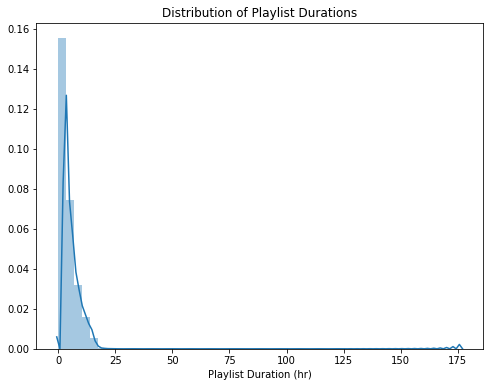

In [46]:
pl_dur['duration_hr'] = (pl_dur['total_dur']/(1000*60*60))

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax = sns.distplot(pl_dur['duration_hr'])
ax.set_xlabel('Playlist Duration (hr)')
ax.set_title('Distribution of Playlist Durations');

In [47]:
#get summary stats
pl_dur['duration_hr'].describe()

count    1000000.000000
mean           4.327688
std            3.571232
min            0.027094
25%            1.665384
50%            3.172899
75%            5.953802
max          176.409387
Name: duration_hr, dtype: float64

In [116]:
#composition of the playlist with the longest duration
longest_pl = pl_dur.loc[pl_dur['duration_hr'] == pl_dur['duration_hr'].max()].iloc[0]['pidfile_name']
pl_length.loc[pl_length['pidfile_name']==longest_pl]

,num_songs,pidfile_name
588331,216,62songs397


In [122]:
#composition of the playlist with the shortest duration
shortest_pl = pl_dur.loc[pl_dur['duration_hr'] == pl_dur['duration_hr'].min()].iloc[0]['pidfile_name']
pl_length.loc[pl_length['pidfile_name']==shortest_pl]

,num_songs,pidfile_name
78422,5,170songs479


In [123]:
#what types of tracks are in these playlists?
pl_song_list = pd.read_sql_query('SELECT track_name, duration_ms FROM mpd \
                                          JOIN songs ON mpd.track_id = songs.track_id \
                                          WHERE mpd.pidfile_name = ?', con, params = {shortest_pl}) #specify which playlist in params

#add column for min duration of tracks
pl_song_list['duration_min'] = (pl_song_list['duration_ms']/(1000*60))
pl_song_list.head()

,track_name,duration_ms,duration_min
0,Johnny's Theme - The Tonight Show Theme,77826,1.297100
1,Applause (Version 1) [People Clapping Hands Au...,7006,0.116767
2,Applause Crowd Group Small Theatre Audience Pe...,6706,0.111767
3,Crowd Laughter (Version 3) [People Laughing La...,3000,0.050000
4,Cricket Chirps,3000,0.050000


In [120]:
#composition of the playlist with the shortest duration
shortest_pl = pl_dur.loc[pl_dur['duration_hr'] == pl_dur['duration_hr'].min()]
shortest_pl
#pl_length.loc[pl_length['pidfile_name']==shortest_pl]

,total_dur,pidfile_name,duration_min,duration_hr
78422,97538,170songs479,1.625633,0.027094


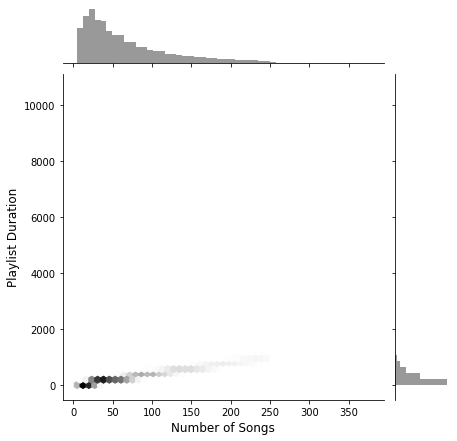

In [44]:
#plot relationship between playlist length and duration - should be linear
ax = sns.jointplot(x=pl_length['num_songs'].to_numpy(), y=pl_dur['duration_min'].to_numpy(), kind="hex", color="k");
ax.set_axis_labels('Number of Songs', 'Playlist Duration', fontsize=12)

In [15]:
#what are the top common song names
cur = con.cursor()

cur.execute('SELECT COUNT(track_id) AS counts, track_name \
            FROM songs GROUP BY track_name ORDER BY counts DESC LIMIT 10')
cur.fetchall()

[(1559, 'Intro'),
 (946, 'Silent Night'),
 (843, 'Home'),
 (617, 'White Christmas'),
 (554, 'O Holy Night'),
 (537, 'Jingle Bells'),
 (508, 'Amazing Grace'),
 (498, 'Stay'),
 (476, 'Hold On'),
 (465, 'Forever')]

In [16]:
#plot distribution of song durations
df = pd.read_sql_query('SELECT track_name, duration_ms FROM songs',con)

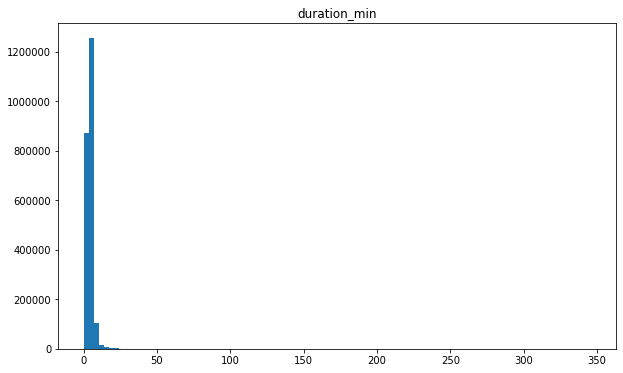

In [17]:
df['duration_min'] = (df['duration_ms']/(1000*60))
df.hist(column = 'duration_min',figsize = (10,6), grid = False, bins = 100);

In [126]:
#what are the most featured artists?
top10_artists = pd.read_sql_query('SELECT artist_name, COUNT(artist_id) AS popularity FROM mpd \
                                   JOIN songs ON mpd.track_id = songs.track_id \
                                   JOIN artists ON songs.artist_id = artists.id \
                                   GROUP BY artist_name \
                                   ORDER BY popularity DESC LIMIT 10', con)
top10_artists

,artist_name,popularity
0,Drake,847160
1,Kanye West,413297
2,Kendrick Lamar,353624
3,Rihanna,339570
4,The Weeknd,316603
5,Eminem,294667
6,Ed Sheeran,272116
7,Future,250734
8,Justin Bieber,243119
9,J. Cole,241560


In [18]:
#what is the long tail? audiobooks, british ones
df.sort_values(by='duration_min', ascending = False).head()

,track_name,duration_ms,duration_min
1291723,The Hound of the Baskervilles - Sir Arthur Con...,20744575,345.742917
1291717,The Adventures of Sherlock Holmes - Sir Arthur...,20159059,335.984317
1955383,Pride and Prejudice - Jane Austen Part 1 of 2,19672058,327.867633
1955388,Sense and Sensibility - Jane Austen Part 1 of 2,19080542,318.009033
1955389,Sense and Sensibility - Jane Austen Part 2 of 2,19043395,317.389917


In [19]:
#some errors in the duration column - songs with no duration
#would have to fix manually, but accurate song durations not necessary for recommender algorithm
no_dur_songs = df.loc[df['duration_min'] <= 0]['track_name'].count()
print(f'num songs with no duration: {no_dur_songs}')

num songs with no duration: 52


In [127]:
#close connection to database
con.close()